### 2-3-LiveBeeManualImprovements.ipynb

In [33]:
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import cv2

In [38]:
# Define directories
data_dir = Path("/mnt/g/Projects/Master/Data/")

input_dir = data_dir / "Processed" / "LiveBees" / "2-LiveWingLabelCropsManuallyImproved" / "Labels"
wing_dir = data_dir / "Processed" / "LiveBees" / "3-LiveWingCrops" / "Wings"
output_dir = data_dir / "Processed" / "LiveBees" / "4-LiveWingCropsManuallyImproved" 

DEBUG = True

In [35]:
def approximate_rectangle(corners):
    """
    Approximates a bounding rectangle from the coordinates.
    """
    # Convert list to np array
    points = np.array(corners)
    
    # Find the bounding rectangle
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    
    width = x_max - x_min
    height = y_max - y_min
    
    # Order coordinates correctly 
    return {
        "top_left": (x_min, y_min),
        "top_right": (x_max, y_min),
        "bottom_left": (x_min, y_max),
        "bottom_right": (x_max, y_max)
    }

def crop_image(image_path, corners):
    """
    Crops an image based on coordinates.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or cannot be loaded.")
    
    # Get image dimensions
    img_height, img_width = image.shape[:2]
    
    # Get the approximated rectangle
    rect = approximate_rectangle(corners)
    
    # Extract corner coordinates
    x_min = max(0, min(rect['top_left'][0], img_width - 1))
    x_max = max(0, min(rect['top_right'][0], img_width - 1))
    y_min = max(0, min(rect['top_left'][1], img_height - 1))
    y_max = max(0, min(rect['bottom_left'][1], img_height - 1))
    
    # Ensure coordinates are in correct order
    if x_max <= x_min or y_max <= y_min:
        raise ValueError("Invalid cropping coordinates: resulting area is zero.")
    
    # Crop the image
    cropped_image = image[y_min:y_max, x_min:x_max]
    
    if cropped_image.size == 0:
        raise ValueError("Cropped image is empty.")
    
    # Rotate if necessary to have the longest side at the bottom
    h, w = cropped_image.shape[:2]
    if h > w:
        cropped_image = cv2.rotate(cropped_image, cv2.ROTATE_90_CLOCKWISE)
    
    return cropped_image

Processing files:   6%|█████▏                                                                                  | 70/1194 [00:05<01:49, 10.30it/s]

Round01-Hive02-2024_06_07-h02bee21


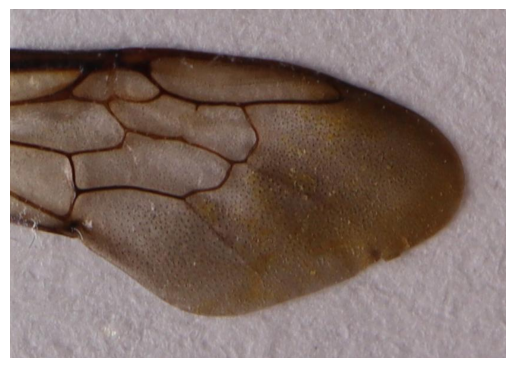

Processing files:  20%|█████████████████▋                                                                     | 242/1194 [00:16<01:06, 14.26it/s]

Round01-Hive04-2024_06_17-h04b17


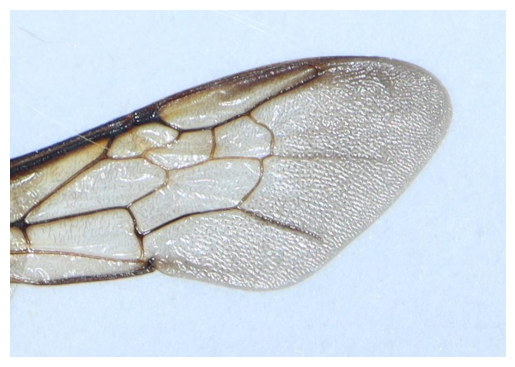

Processing files:  22%|███████████████████▍                                                                   | 266/1194 [00:18<01:09, 13.34it/s]

Round01-Hive04-2024_06_26-h04b47


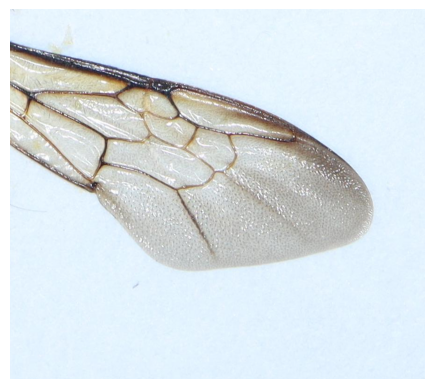

Processing files:  24%|████████████████████▋                                                                  | 284/1194 [00:20<01:10, 12.92it/s]

Round01-Hive05-2024_06_13-h05b02


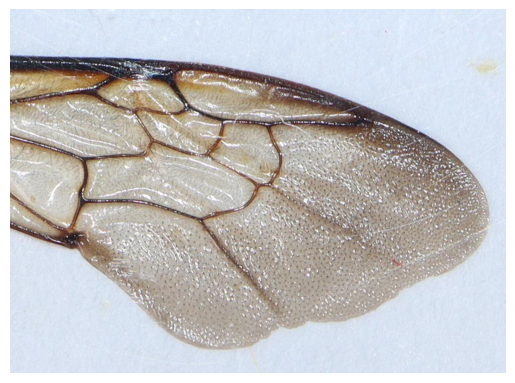

Processing files:  28%|████████████████████████▏                                                              | 332/1194 [00:24<01:02, 13.79it/s]

Round01-Hive05-2024_06_28-h05b90


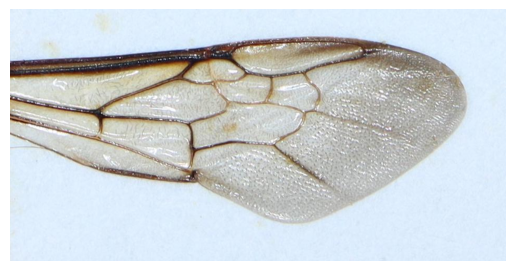

Processing files:  48%|██████████████████████████████████████████                                             | 578/1194 [00:43<00:45, 13.60it/s]

Round02-hive14-2024_07_04-h14b38


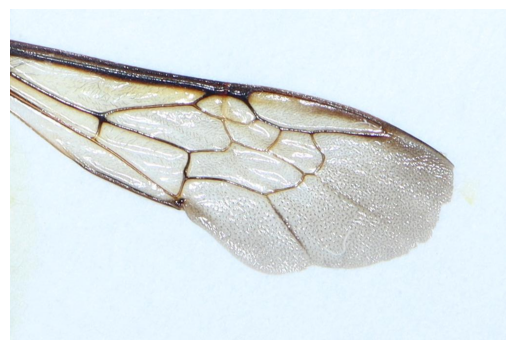

Processing files:  54%|███████████████████████████████████████████████▎                                       | 650/1194 [00:49<00:40, 13.40it/s]

Round02-hive15-2024_07_10-h15b24


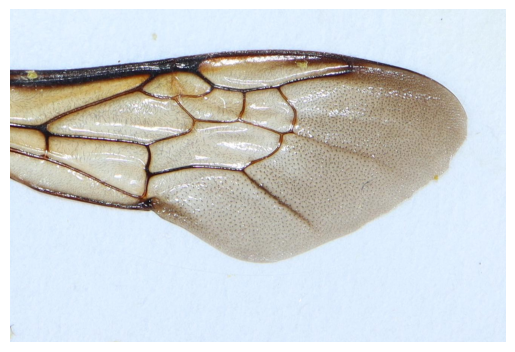

Processing files:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 1076/1194 [01:30<00:08, 13.65it/s]

Round04-hive34-2024_07_19-h34b15


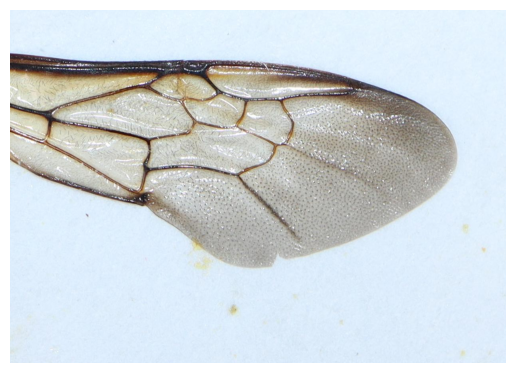

Processing files:  95%|██████████████████████████████████████████████████████████████████████████████████    | 1140/1194 [01:35<00:03, 14.77it/s]

Round04-hive35-2024_07_19-h35b02


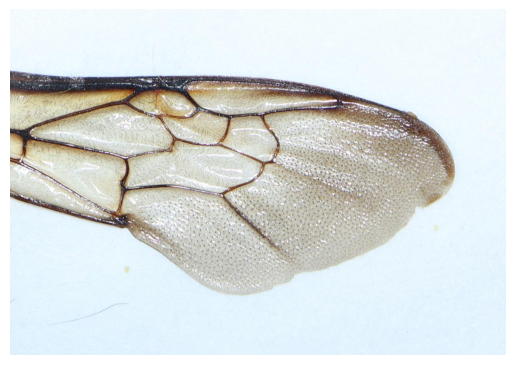

Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1194/1194 [01:39<00:00, 11.99it/s]


In [41]:
# Rectangular coordinates identified using the helper script
recrop_wings = {
        "Round01-Hive02-2024_06_07-h02bee21": ((1554, 1383), (1560, 575), (2122, 552), (2141, 1387)), 
        "Round01-Hive04-2024_06_17-h04b17": ((1521, 1446), (1465, 625), (2021, 568), (2080, 1428)), 
        "Round01-Hive05-2024_06_13-h05b02": ((2250, 162), (2184, 1182), (1502, 1153), (1594, 164)), 
        "Round01-Hive04-2024_06_26-h04b47": ((1596, 1416), (1988, 1467), (2388, 688), (1853, 579)), 
        "Round01-Hive05-2024_06_28-h05b90": ((1699, 1801), (1696, 863), (2177, 854), (2144, 1777)), 
        "Round02-hive14-2024_07_04-h14b38": ((1610, 1372), (1873, 443), (2288, 535), (2016, 1459)), 
        "Round02-hive15-2024_07_10-h15b24": ((1517, 1436), (1556, 128), (2402, 149), (2234, 1448)), 
        "Round04-hive34-2024_07_19-h34b15": ((1559, 1391), (1726, 170), (2449, 221), (2140, 1419)), 
        "Round04-hive35-2024_07_19-h35b02": ((1450, 1491), (1705, 110), (2413, 156), (2192, 1485)),
        }

try:
    # Create the new output directories
    if os.path.exists(output_dir):
        print("WARNING: Output directory already exists.") 
    os.makedirs(output_dir, exist_ok=True)
    
    # Find jpg files
    jpg_files = list(input_dir.glob("*.JPG"))
    for jpg_file in  tqdm(jpg_files, desc="Processing files", ncols=145):
        filename = jpg_file.stem
            
        if filename in recrop_wings.keys():
            cropped_image = crop_image(jpg_file, recrop_wings[filename])
            cv2.imwrite(output_dir / jpg_file.name, cropped_image)
            
            if DEBUG:
                print(filename)
                plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
                plt.axis("off")
                plt.show()

        else: 
            # Copy the image
            source_jpg = wing_dir / jpg_file.name
            destination_jpg = output_dir / jpg_file.name
            shutil.copy(source_jpg, destination_jpg)

# Handle exceptions
except FileNotFoundError as e:
    print(e)

except ValueError as e:
    print(e)

except KeyboardInterrupt:
    pass

In [9]:
# Marker lengths identified using the helper script
missing_markers = {
        "Round01-Hive01-2024_06_19-h01b21": 0,
        "Round01-Hive02-2024_06_18-h02b12": 0,
        "Round01-Hive02-2024_06_18-h02b44": 0,
        "Round01-Hive04-2024_06_17-h04b07": 0,
        "Round01-Hive04-2024_06_17-h04b13": 0,
        "Round01-Hive05-2024_06_13-h05b02": 0,
        "Round01-Hive05-2024_06_13-h05b33": 0,
        "Round02-hive11-2024_06_18-h11b04": 0,
        "Round02-hive11-2024_06_18-h11b05": 0,
        "Round02-hive11-2024_06_18-h11b13": 0,
        "Round02-hive11-2024_06_18-h11b17": 0,
        "Round02-hive11-2024_06_18-h11b19": 0,
        "Round02-hive11-2024_06_18-h11b21": 0
        }